<a href="https://colab.research.google.com/github/xaldoxxx/BlockDeNotas/blob/main/apuestas002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# extraer resultados de https://argentina.as.com/resultados/futbol/argentina/2023/jornada/
# desde la fecha 1 a la 27
# script01.py
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re

class Partido:
    id_counter = 1

    def __init__(self, local, visitante, resultado, fecha):
        self.id = Partido.id_counter
        Partido.id_counter += 1
        self.local = local
        self.visitante = visitante
        self.resultado = resultado
        self.fecha = fecha
    
    def guardar_csv(self, filename):
        data = {'ID': self.id, 'Fecha': self.fecha, 'EquipoLocal': self.local, 'EquipoVisitante': self.visitante, 'GLocal': self.resultado[0], 'GVisitante': self.resultado[1]}
        df = pd.DataFrame([data])
        mode = 'w' if not os.path.exists(filename) else 'a'
        df.to_csv(filename, mode=mode, index=False, header=not os.path.exists(filename))

    def mostrar_info(self):
        print(f'ID: {self.id}')
        print(f'Local: {self.local}')
        print(f'Visitante: {self.visitante}')
        print(f'Resultado: {self.resultado}')
        print(f'Fecha: {self.fecha}')

    @staticmethod
    def inferir_fecha(element):
        soup = BeautifulSoup(element, 'html.parser')
        fecha_element = soup.find('span', class_='fecha')
        fecha = fecha_element.text.strip()
        fecha_inferida = fecha.split('-')[1].strip()
        return fecha_inferida

    @classmethod
    def crear_partidos(cls, url):
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        partidos_element = soup.find_all('li', class_='list-resultado')
        partidos = []
        for partido_element in partidos_element:
            local = partido_element.find('div', class_='equipo-local').find('span', class_='nombre-equipo').text.strip()
            visitante = partido_element.find('div', class_='equipo-visitante').find('span', class_='nombre-equipo').text.strip()
            resultado_element = partido_element.find('div', class_='cont-resultado').find('a', class_='resultado')
            resultado = resultado_element.text.strip() if resultado_element is not None else 'N/A'
            valores = re.findall(r'\d+', resultado)
            resultado_local = int(valores[0]) if valores else 0
            resultado_visitante = int(valores[1]) if len(valores) > 1 else 0
            fecha_element = partido_element.find('div', class_='info-evento').find('span', class_='fecha')
            fecha = cls.inferir_fecha(str(fecha_element))
            partido = cls(local, visitante, (resultado_local, resultado_visitante), fecha)
            partidos.append(partido)
        return partidos

# Obtener la página web
url_base = "https://argentina.as.com/resultados/futbol/argentina/2023/jornada/regular_a_"
partidos = []

# Iterar sobre las jornadas desde regular_a_1 hasta regular_a_16
for i in range(1, 27):
    url = url_base + str(i) + "/"
    partidos.extend(Partido.crear_partidos(url))

# Guardar en archivo CSV y mostrar información de los partidos
filename = 'partidos.csv'
for partido in partidos:
    partido.guardar_csv(filename)
    #partido.mostrar_info

In [ ]:
# script02.py
import pandas as pd
import csv

class EquipoData:
    """
    Clase para calcular estadísticas de equipos de fútbol.
    
    Uso:
    ----
    # Crear una instancia de la clase EquipoData
    equipo_data = EquipoData(df)
    
    # Filtrar y obtener datos para un equipo específico
    equipo_df = equipo_data.filtrar_por_equipo('Equipo1')
    
    # Obtener estadísticas para el equipo
    promedio_goles_favor = equipo_data.calcular_promedio_goles_favor('Equipo1')
    promedio_goles_contra = equipo_data.calcular_promedio_goles_contra('Equipo1')
    diferencia_goles = equipo_data.calcular_diferencia_goles('Equipo1')
    
    # Mostrar información de ayuda
    help(EquipoData)
    """

    def __init__(self, df):
        """
        Inicializa una instancia de EquipoData con un DataFrame de datos.
        
        Parámetros:
        -----------
        df : pandas.DataFrame
            DataFrame con los datos de los partidos.
        """
        self.df = df


    def filtrar_por_equipo(self, equipo):
        """
        Filtra los datos por un equipo específico y calcula estadísticas relacionadas.
        
        Parámetros:
        -----------
        equipo : str
            Nombre del equipo a filtrar.
        
        Retorna:
        --------
        pandas.DataFrame
            DataFrame filtrado con los datos del equipo y las estadísticas calculadas.
        """
        equipo_local = self.df[self.df['EquipoLocal'] == equipo].copy()
        equipo_local['Resultado'] = (equipo_local['GLocal'] - equipo_local['GVisitante']).map(lambda x: 1 if x > 0 else -1 if x < 0 else 0)
        
        equipo_visitante = self.df[self.df['EquipoVisitante'] == equipo].copy()
        equipo_visitante['Resultado'] = (equipo_visitante['GVisitante'] - equipo_visitante['GLocal']).map(lambda x: 1 if x > 0 else -1 if x < 0 else 0)
        
        equipo_data = pd.concat([equipo_local, equipo_visitante])
        
        equipo_data['PromedioGolesFavor'] = equipo_data.groupby('EquipoLocal')['GLocal'].transform('mean')
        equipo_data['PromedioGolesContra'] = equipo_data.groupby('EquipoLocal')['GVisitante'].transform('mean')
        equipo_data['DiferenciaGoles'] = equipo_data['GLocal'] - equipo_data['GVisitante']
        equipo_data['PromedioPuntos'] = equipo_data.groupby('EquipoLocal')['Resultado'].transform('mean')
        
        equipo_data['Victorias'] = (equipo_data['Resultado'] == 1).astype(int)
        equipo_data['Empates'] = (equipo_data['Resultado'] == 0).astype(int)
        equipo_data['Derrotas'] = (equipo_data['Resultado'] == -1).astype(int)
        equipo_data['PorcentajeVictorias'] = equipo_data.groupby('EquipoLocal')['Victorias'].transform('mean')
        equipo_data['PorcentajeEmpates'] = equipo_data.groupby('EquipoLocal')['Empates'].transform('mean')
        equipo_data['PorcentajeDerrotas'] = equipo_data.groupby('EquipoLocal')['Derrotas'].transform('mean')
        
        equipo_data['MasDe2Goles'] = (equipo_data['GLocal'] + equipo_data['GVisitante'] > 2).astype(int)
        equipo_data['MenosDe2Goles'] = (equipo_data['GLocal'] + equipo_data['GVisitante'] < 2).astype(int)
        equipo_data['PorcentajeMasDe2Goles'] = equipo_data.groupby('EquipoLocal')['MasDe2Goles'].transform('mean')
        equipo_data['PorcentajeMenosDe2Goles'] = equipo_data.groupby('EquipoLocal')['MenosDe2Goles'].transform('mean')
        
        equipo_data['PartidosAnteriores'] = equipo_data.groupby('EquipoLocal').cumcount()
        
        return equipo_data

    def calcular_promedio_goles_favor(self, equipo):
        """
        Calcula el promedio de goles a favor de un equipo específico.
        
        Parámetros:
        -----------
        equipo : str
            Nombre del equipo.
        
        Retorna:
        --------
        float
            Promedio de goles a favor del equipo.
        """
        equipo_df = self.filtrar_por_equipo(equipo)
        return equipo_df['PromedioGolesFavor'].iloc[0]

    def calcular_promedio_goles_contra(self, equipo):
        """
        Calcula el promedio de goles en contra de un equipo específico.
        
        Parámetros:
        -----------
        equipo : str
            Nombre del equipo.
        
        Retorna:
        --------
        float
            Promedio de goles en contra del equipo.
        """
        equipo_df = self.filtrar_por_equipo(equipo)
        return equipo_df['PromedioGolesContra'].iloc[0]

    def calcular_diferencia_goles(self, equipo):
        """
        Calcula la diferencia de goles de un equipo específico.
        
        Parámetros:
        -----------
        equipo : str
            Nombre del equipo.
        
        Retorna:
        --------
        float
            Diferencia de goles del equipo.
        """
        equipo_df = self.filtrar_por_equipo(equipo)
        return equipo_df['DiferenciaGoles'].mean()

    def calcular_promedio_puntos(self, equipo):
        """
        Calcula el promedio de puntos por partido de un equipo específico.
        
        Parámetros:
        -----------
        equipo : str
            Nombre del equipo.
        
        Retorna:
        --------
        float
            Promedio de puntos por partido del equipo.
        """
        equipo_df = self.filtrar_por_equipo(equipo)
        return equipo_df['PromedioPuntos'].mean()

    def calcular_porcentaje_victorias(self, equipo):
        """
        Calcula el porcentaje de victorias de un equipo específico.
        
        Parámetros:
        -----------
        equipo : str
            Nombre del equipo.
        
        Retorna:
        --------
        float
            Porcentaje de victorias del equipo.
        """
        equipo_df = self.filtrar_por_equipo(equipo)
        return equipo_df['PorcentajeVictorias'].iloc[0]

    def calcular_porcentaje_empates(self, equipo):
        """
        Calcula el porcentaje de empates de un equipo específico.
        
        Parámetros:
        -----------
        equipo : str
            Nombre del equipo.
        
        Retorna:
        --------
        float
            Porcentaje de empates del equipo.
        """
        equipo_df = self.filtrar_por_equipo(equipo)
        return equipo_df['PorcentajeEmpates'].iloc[0]

    def calcular_porcentaje_derrotas(self, equipo):
        """
        Calcula el porcentaje de derrotas de un equipo específico.
        
        Parámetros:
        -----------
        equipo : str
            Nombre del equipo.
        
        Retorna:
        --------
        float
            Porcentaje de derrotas del equipo.
        """
        equipo_df = self.filtrar_por_equipo(equipo)
        return equipo_df['PorcentajeDerrotas'].iloc[0]

    def calcular_porcentaje_mas_de_2_goles(self, equipo):
        """
        Calcula el porcentaje de partidos en los que un equipo específico anotó más de 2 goles.
        
        Parámetros:
        -----------
        equipo : str
            Nombre del equipo.
        
        Retorna:
        --------
        float
            Porcentaje de partidos con más de 2 goles del equipo.
        """
        equipo_df = self.filtrar_por_equipo(equipo)
        return equipo_df['PorcentajeMasDe2Goles'].mean()

    def calcular_porcentaje_menos_de_2_goles(self, equipo):
        """
        Calcula el porcentaje de partidos en los que un equipo específico anotó menos de 2 goles.
        
        Parámetros:
        -----------
        equipo : str
            Nombre del equipo.
        
        Retorna:
        --------
        float
            Porcentaje de partidos con menos de 2 goles del equipo.
        """
        equipo_df = self.filtrar_por_equipo(equipo)
        return equipo_df['PorcentajeMenosDe2Goles'].mean()

    def calcular_historial_enfrentamientos(self, equipo):
        """
        Calcula el número de partidos anteriores de un equipo específico.
        
        Parámetros:
        -----------
        equipo : str
            Nombre del equipo.
        
        Retorna:
        --------
        int
            Número de partidos anteriores del equipo.
        """
        equipo_df = self.filtrar_por_equipo(equipo)
        return equipo_df['PartidosAnteriores'].max()

    def obtener_estadisticas_equipo(self, equipo):
        """
        Obtiene todas las estadísticas de un equipo específico.
        
        Parámetros:
        -----------
        equipo : str
            Nombre del equipo.
        
        Retorna:
        --------
        dict
            Diccionario con todas las estadísticas del equipo.
        """
        estadisticas = {}
        estadisticas['PromedioGolesFavor'] = self.calcular_promedio_goles_favor(equipo)
        estadisticas['PromedioGolesContra'] = self.calcular_promedio_goles_contra(equipo)
        estadisticas['DiferenciaGoles'] = self.calcular_diferencia_goles(equipo)
        estadisticas['PromedioPuntos'] = self.calcular_promedio_puntos(equipo)
        estadisticas['PorcentajeVictorias'] = self.calcular_porcentaje_victorias(equipo)
        estadisticas['PorcentajeEmpates'] = self.calcular_porcentaje_empates(equipo)
        estadisticas['PorcentajeDerrotas'] = self.calcular_porcentaje_derrotas(equipo)
        estadisticas['PorcentajeMasDe2Goles'] = self.calcular_porcentaje_mas_de_2_goles(equipo)
        estadisticas['PorcentajeMenosDe2Goles'] = self.calcular_porcentaje_menos_de_2_goles(equipo)
        estadisticas['HistorialEnfrentamientos'] = self.calcular_historial_enfrentamientos(equipo)
        return estadisticas

    def imprimir_estadisticas_equipo(self, equipo):
        """
        Imprime todas las estadísticas de un equipo específico.
        
        Parámetros:
        -----------
        equipo : str
            Nombre del equipo.
        """
        estadisticas = self.obtener_estadisticas_equipo(equipo)
        print("Estadísticas del equipo:", equipo)
        print("Promedio de goles a favor:", estadisticas['PromedioGolesFavor'])
        print("Promedio de goles en contra:", estadisticas['PromedioGolesContra'])
        print("Diferencia de goles:", estadisticas['DiferenciaGoles'])
        print("Promedio de puntos por partido:", estadisticas['PromedioPuntos'])
        print("Porcentaje de victorias:", estadisticas['PorcentajeVictorias'])
        print("Porcentaje de empates:", estadisticas['PorcentajeEmpates'])
        print("Porcentaje de derrotas:", estadisticas['PorcentajeDerrotas'])
        print("Porcentaje de partidos con más de 2 goles:", estadisticas['PorcentajeMasDe2Goles'])
        print("Porcentaje de partidos con menos de 2 goles:", estadisticas['PorcentajeMenosDe2Goles'])
        print("Historial de enfrentamientos directos:", estadisticas['HistorialEnfrentamientos'])
        print("----------------------------------------")




    def guardar_estadisticas_csv(self, archivo_salida):
        """
        Guarda las estadísticas de todos los equipos en un archivo CSV.
        
        Parámetros:
        -----------
        archivo_salida : str
            Ruta del archivo CSV de salida.
        """
        with open(archivo_salida, 'w', newline='') as csvfile:
            fieldnames = [
                'Equipo',
                'PromedioGolesFavor',
                'PromedioGolesContra',
                'DiferenciaGoles',
                'PromedioPuntos',
                'PorcentajeVictorias',
                'PorcentajeEmpates',
                'PorcentajeDerrotas',
                'PorcentajeMasDe2Goles',
                'PorcentajeMenosDe2Goles',
                'HistorialEnfrentamientos'
            ]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()

            for equipo in self.equipos:
                estadisticas = self.obtener_estadisticas_equipo(equipo)
                estadisticas['Equipo'] = equipo
                writer.writerow(estadisticas)


# Cargar los datos del archivo CSV en un DataFrame
df = pd.read_csv("/content/partidos.csv")

# Crear una instancia de la clase EquipoData
equipo_data = EquipoData(df)

# Obtener una lista única de todos los equipos presentes en los datos
equipos = df['EquipoLocal'].unique().tolist() + df['EquipoVisitante'].unique().tolist()

# Filtrar los datos para cada equipo (equipo.islower() si queremos todo en minuscula)y guardar en archivos CSV individuales
for equipo in equipos:
    equipo_df = equipo_data.filtrar_por_equipo(equipo)
    nombre_archivo = equipo + ".csv"
    nombre_archivo = nombre_archivo.replace(" ", "")  # Reemplazar espacios por nada
    equipo_df.to_csv(nombre_archivo, index=False)
    print("Los datos del equipo", equipo, "se han guardado en el archivo:", nombre_archivo)



Los datos del equipo Rosario Central se han guardado en el archivo: RosarioCentral.csv
Los datos del equipo Defensa y Justicia se han guardado en el archivo: DefensayJusticia.csv
Los datos del equipo San Lorenzo de Almagro se han guardado en el archivo: SanLorenzodeAlmagro.csv
Los datos del equipo Estudiantes se han guardado en el archivo: Estudiantes.csv
Los datos del equipo Talleres se han guardado en el archivo: Talleres.csv
Los datos del equipo Central Córdoba (Santiago del Estero) se han guardado en el archivo: CentralCórdoba(SantiagodelEstero).csv
Los datos del equipo Platense se han guardado en el archivo: Platense.csv
Los datos del equipo Racing Club se han guardado en el archivo: RacingClub.csv
Los datos del equipo Colón de Santa Fe se han guardado en el archivo: ColóndeSantaFe.csv
Los datos del equipo I. Córdoba se han guardado en el archivo: I.Córdoba.csv
Los datos del equipo Boca Juniors se han guardado en el archivo: BocaJuniors.csv
Los datos del equipo Barracas Central se

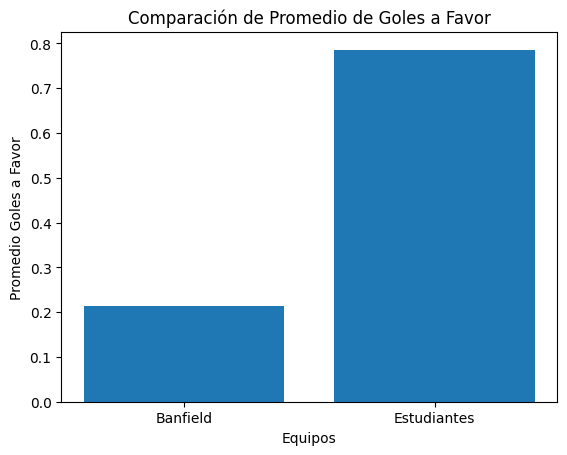

Resultado predicho del partido: Gana Estudiantes
Probabilidad del resultado segun racha actual: 0.7857142857142857


In [ ]:
# script03.py
# pronostico segun racha actual
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los DataFrames
df_banfield = pd.read_csv('/content/Banfield.csv')
df_estudiantes = pd.read_csv('/content/Estudiantes.csv')

# Crear instancias de EquipoData para ambos DataFrames
equipo_data_banfield = EquipoData(df_banfield)
equipo_data_estudiantes = EquipoData(df_estudiantes)

# Obtener las estadísticas de cada equipo
estadisticas_banfield = equipo_data_banfield.obtener_estadisticas_equipo('Banfield')
estadisticas_estudiantes = equipo_data_estudiantes.obtener_estadisticas_equipo('Estudiantes')

# Realizar la comparación de estadísticas y predecir el resultado
if estadisticas_banfield['PromedioGolesFavor'] > estadisticas_estudiantes['PromedioGolesFavor']:
    resultado_predicho = 'Gana Banfield'
    probabilidad = estadisticas_banfield['PromedioGolesFavor'] / (estadisticas_banfield['PromedioGolesFavor'] + estadisticas_estudiantes['PromedioGolesFavor'])
elif estadisticas_banfield['PromedioGolesFavor'] < estadisticas_estudiantes['PromedioGolesFavor']:
    resultado_predicho = 'Gana Estudiantes'
    probabilidad = estadisticas_estudiantes['PromedioGolesFavor'] / (estadisticas_banfield['PromedioGolesFavor'] + estadisticas_estudiantes['PromedioGolesFavor'])
else:
    resultado_predicho = 'Empate'
    probabilidad = 0.5

# Crear un gráfico de barras para comparar las estadísticas
equipos = ['Banfield', 'Estudiantes']
promedio_goles_favor = [estadisticas_banfield['PromedioGolesFavor'], estadisticas_estudiantes['PromedioGolesFavor']]

plt.bar(equipos, promedio_goles_favor)
plt.xlabel('Equipos')
plt.ylabel('Promedio Goles a Favor')
plt.title('Comparación de Promedio de Goles a Favor')
plt.show()

print('Resultado predicho del partido:', resultado_predicho)
print('Probabilidad del resultado segun racha actual:', probabilidad)